In [233]:
import csv
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from datagen import _relative_points

In [294]:
weights = {
    'blouse': np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
    'dress': np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0]),
    'outwear': np.array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
    'skirt': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0]),
    'trousers': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1])
}

In [299]:
def generate_train_set(source, target, reorder=False):
    with open(source, newline='') as infile:
        spamreader = csv.reader(infile)
        with open(target, 'w', newline='') as outfile:
            spamwriter = csv.writer(outfile, delimiter=' ')
            
            # keep track of some variables
            head = True
            catagories = {'blouse':[], 'dress':[], 'outwear':[], 'skirt':[], 'trousers':[]}
            image_count = {'blouse':[0, 0], 'dress':[0, 0], 'outwear':[0, 0], 'skirt':[0, 0], 'trousers':[0, 0]}
            trimmed = [0, 0]
            
            # process every row
            for row in spamreader:
                # skip the header row
                if head:
                    head = False
                    continue
                    
                bad_data = False

                # parse data
                this_row = [row[0].split('/')[-1], row[1]]
                img = Image.open('data/train/Images/' + row[0].split('/')[-1])
                img_size = img.size
                
                for i in range(2, 26):
                    x, y, v = row[i].split('_')
                    
                    # pickout data with invalid points
                    if v == '1' and weights[row[1]][i-2] == 0:
                        bad_data = True
                        break
#                     elif v == '-1' and weights[row[1]][i-2] == 1:
#                         bad_data = True
#                         break

                    x = int(x)
                    y = int(y)
                    if x == img_size[0]:
                        x -= 1
                        trimmed[0] += 1
                    if y == img_size[1]:
                        y -= 1
                        trimmed[1] += 1
                        
                    this_row += [x, y, v]

                # pickout data without valid normalization points
                if row[1] in ['blouse', 'outwear', 'dress']:
                    if row[7].split('_')[2] == "-1" or row[8].split('_')[2] == "-1":
                        bad_data = True
                else:
                    if row[17].split('_')[2] == "-1" or row[18].split('_')[2] == "-1":
                        bad_data = True
                        
                if bad_data:
                    image_count[row[1]][1] += 1    
                elif reorder:
                    catagories[row[1]].append(this_row)
                else:
                    spamwriter.writerow(this_row)
             
            if reorder:
                # calculate total count
                for i in catagories:
                    image_count[i][0] = len(catagories[i])

                # write 90% of every catagory as train set
                for i in catagories:
                    train_size = int(len(catagories[i]) * 0.9)
                    for row in catagories[i][:train_size]:
                        spamwriter.writerow(row)

                # write 10% of every catagory as valid set
                for i in catagories:
                    train_size = int(len(catagories[i]) * 0.9)
                    for row in catagories[i][train_size:]:
                        spamwriter.writerow(row)
                    
            return image_count, trimmed 

In [300]:
image_count, trimmed = generate_train_set("data/train/Annotations/train.csv", 
                                 'data/train/dataset.txt', reorder=False)
print(image_count, trimmed)

{'blouse': [0, 34], 'dress': [0, 24], 'outwear': [0, 31], 'skirt': [0, 16], 'trousers': [0, 31]} [11, 10]


In [301]:
from datagen import DataGenerator
from utils import read_config
print('--Parsing Config File')
params = read_config('config.cfg')

print('--Creating Dataset')
dataset = DataGenerator(params['points_list'],
                        params['img_directory'], params['training_txt_file'])
dataset.generate_set(rand=True)

--Parsing Config File
--Creating Dataset
READING TRAIN DATA
SET CREATED
--Training set : 28345  samples.
--Validation set : 3150  samples.


In [302]:
random.shuffle(dataset.valid_set)
generator = dataset.generator(params['img_size'], params['hm_size'], 1, params['num_classes'],
                                  params['nstacks'], normalize=True, sample_set='valid')


In [303]:
num_zero_coord = [0, 0]
num_max_coord = [0, 0]
for i in tqdm(range(len(dataset.valid_set))):
    name = dataset.valid_set[i]
    images, labels, hms, weights = next(generator)
    
#     print("\r", i)
    
print("[x, y] == zero:", num_zero_coord)
print("[x, y] >= image_size:", num_max_coord)

100%|██████████| 3150/3150 [00:24<00:00, 128.97it/s]

[x, y] == zero: [0, 0]
[x, y] >= image_size: [0, 0]


label: 4
None zero in heatmap:  4
(array([], dtype=int64), array([], dtype=int64))
[]
[]
norm dist: 0.0


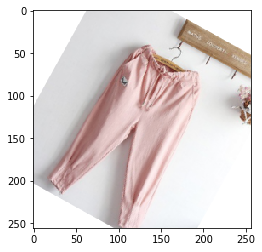

In [291]:
images, gt_labels, gt_maps, weights = next(generator)
gt_map = gt_maps[0, 0, :, :, :]
label = np.argmax(gt_labels, axis=1)

print("label:", label[0])
if label[0] <= 2:
    norm_idx1 = np.array(np.where(gt_map[:, :, 5] == 1))
    norm_idx2 = np.array(np.where(gt_map[:, :, 6] == 1))
    print("None zero in heatmap: ", np.count_nonzero(gt_map[:, :, 5]))
    print(np.where(gt_map[:, :, 5] != 0))
else:
    norm_idx1 = np.array(np.where(gt_map[:, :, 15] == 1))
    norm_idx2 = np.array(np.where(gt_map[:, :, 16] == 1))
    print("None zero in heatmap: ", np.count_nonzero(gt_map[:, :, 15]))
    print(np.where(gt_map[:, :, 15] == 1))

print(norm_idx1)
print(norm_idx2)
norm_dist = np.linalg.norm(norm_idx2 - norm_idx1)
print('norm dist:', norm_dist)

image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
name = 'e13e5efe8f1b1a6b61275eb092961e9a.jpg'
point = dataset.data_dict[name]['points']
img = dataset.open_img(name)
new_p = _relative_points(point, img.shape)
print(new_p)
print(img.shape)
new_p = np.round(new_p * 64 / max(img.shape))
print(new_p)

In [ ]:
img = dataset.open_img('e13e5efe8f1b1a6b61275eb092961e9a.jpg')
plt.imshow(img)
plt.show()